In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class PokerCardDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if os.path.isfile(os.path.join(image_dir, f))
        ])

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace('.jpg', '.txt'))

        img = Image.open(img_path).convert("RGB")
        abs_width, abs_height = img.size  # for converting yolo coords
        boxes = []
        labels = []

        with open(label_path) as f:
            for line in f:
                cls, cx, cy, w, h = map(float, line.strip().split())
                x1 = (cx - w / 2) * abs_width
                y1 = (cy - h / 2) * abs_height
                x2 = (cx + w / 2) * abs_width
                y2 = (cy + h / 2) * abs_height
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transform:
            img = self.transform(img)

        return img, target


    def __len__(self):
        return len(self.images)


In [2]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T

# Initialize Dataset
transform = T.ToTensor()
dataset = PokerCardDataset(image_dir=r"dataset\images", label_dir=r"dataset\labels", transform=transform)

# Split sizes
total_size = len(dataset)
print(total_size)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Splits
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Function to force the dataset items into a format suitable for faster-rcnn, which wants a format like:
# (
#   [image1, image2, ...],
#   [target1, target2, ...]
# ),
#  currently __get_item__ in dataset returns 
# [
#   (image1, target1),
#   (image2, target2),
#   ...
# ]
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, collate_fn=collate_fn)

2117


In [3]:
import torchvision
# import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# import timm
# from torchvision.models.detection.backbone_utils import BackboneWithFPN
# from torchvision.models.detection import FasterRCNN

def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(trainable_backbone_layers=0)

    # Access the ResNet backbone
    resnet_backbone = model.backbone

    # Freeze all layers in the backbone (ResNet-50)
    for param in resnet_backbone.parameters():
        param.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# def get_efficientnet_backbone():
#      # Load EfficientNet-B0 from timm (you can choose other versions of EfficientNet as well)
#     efficientnet_b0 = timm.create_model('efficientnet_b0', pretrained=True)
#     # for block in efficientnet_b0.blocks:
#     #     print(type(block))

#     # Access the blocks in the model
#     blocks = efficientnet_b0.blocks  # 'blocks' holds the Sequential layers

#     with open("efficientnet_b0_blocks.txt", "w") as f:
#         for name, layer in efficientnet_b0.named_children():
#             f.write(f"Layer Name: {name}, Layer: {layer}\n")
    
#     # Extract the feature extractor layers (excluding the classification head)
#     features = nn.Sequential(*list(efficientnet_b0.children())[:-1])

#     # Output channels for EfficientNet-B0 is 1280 (after the last conv block)
#     out_channels = 1280

#     # Wrap this feature extractor in a BackboneWithFPN to provide FPN features
#     backbone = BackboneWithFPN(
#         backbone=features,
#         return_layers = {
#             'blocks.2': '0',  # Low-level features
#             'blocks.3': '1',  # Mid-level features
#             'blocks.4': '2', # High-level features
#         },  # Adjust these layers as per your architecture
#         in_channels_list=[32, 112, 1280],  # Example values, adjust based on EfficientNet
#         out_channels=out_channels
#     )

#     # return backbone

# def get_fasterrcnn_model(num_classes):
#     # Get the custom EfficientNet backbone
#     backbone = get_efficientnet_backbone()
    
#     # Use the custom backbone with Faster R-CNN
#     model = FasterRCNN(
#         backbone,
#         num_classes=num_classes,  # e.g., 52 classes for poker cards (including background class)
#     )

#     return model

# get_efficientnet_backbone()
get_fasterrcnn_model(52)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [4]:
# This will empty the GPU cache
import gc

gc.collect()  # garbage collection for CPU
torch.cuda.empty_cache()  # release unreferenced GPU memory
torch.cuda.ipc_collect()  # collect inter-process memory if needed

print(torch.cuda.is_available()) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True


In [6]:

from torch.optim import SGD
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

torch.cuda.empty_cache()  # release unreferenced GPU memory
model = get_fasterrcnn_model(num_classes=52)
model.to(device)

optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # switch to train mode
    total_loss = 0.0
    
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}")


     # ---------- Validation Loss Loop ----------
    # Use training mode to compute losses (with torch.no_grad()) 
    # so that the forward pass returns a loss dict even for validation data without keeping track of gradients.
    model.train()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_val_loss += sum(loss for loss in loss_dict.values()).item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")

    # ---------- mAP Computation Loop ----------
    model.eval()  # Switch to evaluation mode to get predictions
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            # For metrics, convert targets to same device.
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)  # In eval mode, returns a list of predictions for each image
            all_predictions.extend(preds)
            all_targets.extend(targets)

    # Compute mAP (ensure you have installed pycocotools or torchmetrics[detection])
    map_metric = MeanAveragePrecision()
    map_metric.update(all_predictions, all_targets)
    metrics = map_metric.compute()  # Compute metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] mAP: {metrics['map']:.4f}")


Epoch 0: 100%|██████████| 424/424 [03:43<00:00,  1.90it/s]


Epoch [1/10], Train Loss: 297.6686
Epoch [1/10] Validation Loss: 0.6260
Epoch [1/10] mAP: 0.0000


Epoch 1: 100%|██████████| 424/424 [03:42<00:00,  1.90it/s]


Epoch [2/10], Train Loss: 242.5175
Epoch [2/10] Validation Loss: 0.5209
Epoch [2/10] mAP: 0.0437


Epoch 2: 100%|██████████| 424/424 [03:40<00:00,  1.92it/s]


Epoch [3/10], Train Loss: 174.7006
Epoch [3/10] Validation Loss: 0.3562
Epoch [3/10] mAP: 0.3059


Epoch 3: 100%|██████████| 424/424 [03:41<00:00,  1.92it/s]


Epoch [4/10], Train Loss: 128.5637
Epoch [4/10] Validation Loss: 0.2875
Epoch [4/10] mAP: 0.4417


Epoch 4: 100%|██████████| 424/424 [03:41<00:00,  1.92it/s]


Epoch [5/10], Train Loss: 109.9768
Epoch [5/10] Validation Loss: 0.2543
Epoch [5/10] mAP: 0.4859


Epoch 5: 100%|██████████| 424/424 [03:41<00:00,  1.92it/s]


Epoch [6/10], Train Loss: 97.6057
Epoch [6/10] Validation Loss: 0.2359
Epoch [6/10] mAP: 0.5554


Epoch 6: 100%|██████████| 424/424 [03:40<00:00,  1.92it/s]


Epoch [7/10], Train Loss: 89.0176
Epoch [7/10] Validation Loss: 0.2132
Epoch [7/10] mAP: 0.5765


Epoch 7: 100%|██████████| 424/424 [03:40<00:00,  1.92it/s]


Epoch [8/10], Train Loss: 81.5335
Epoch [8/10] Validation Loss: 0.2079
Epoch [8/10] mAP: 0.5851


Epoch 8: 100%|██████████| 424/424 [03:40<00:00,  1.92it/s]


Epoch [9/10], Train Loss: 76.0482
Epoch [9/10] Validation Loss: 0.1864
Epoch [9/10] mAP: 0.6300


Epoch 9: 100%|██████████| 424/424 [03:43<00:00,  1.90it/s]


Epoch [10/10], Train Loss: 70.2694
Epoch [10/10] Validation Loss: 0.1893
Epoch [10/10] mAP: 0.6565


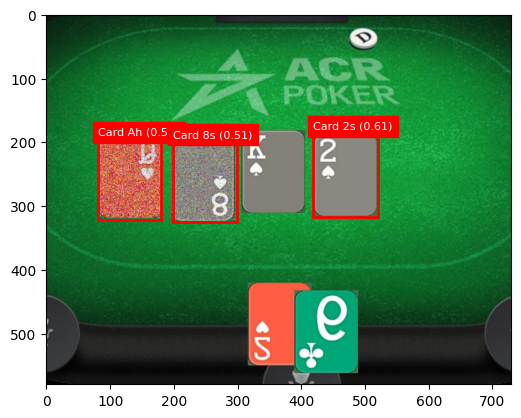

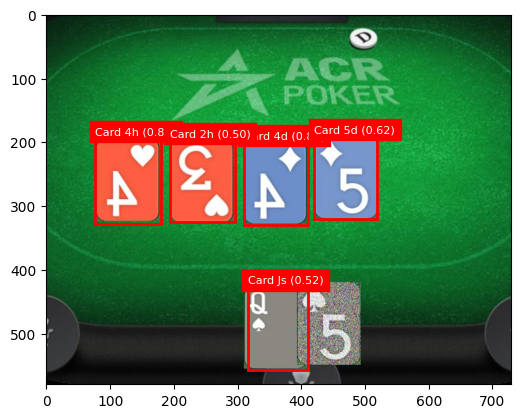

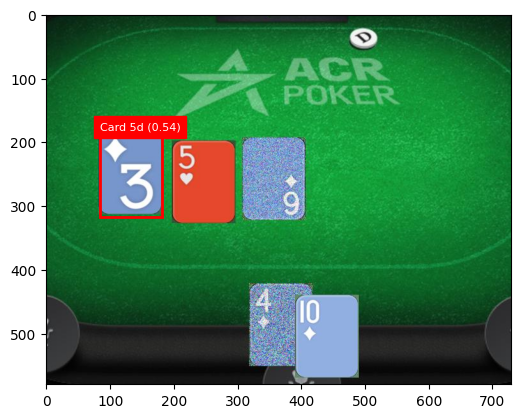

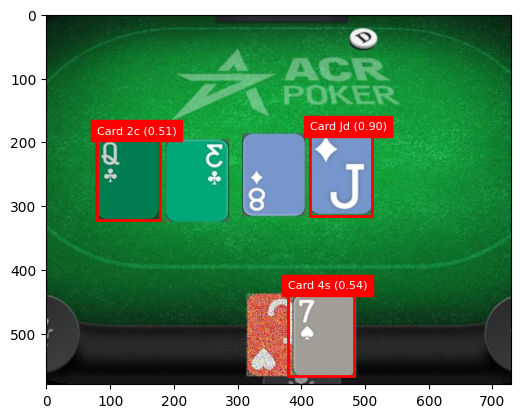

In [ ]:
model.eval()
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

class_names = [
    "10c", "10d", "10h", "10s", "2c", "2d", "2h", "2s", "3c", "3d", "3h", "3s",
    "4c", "4d", "4h", "4s", "5c", "5d", "5h", "5s", "6c", "6d", "6h", "6s",
    "7c", "7d", "7h", "7s", "8c", "8d", "8h", "8s", "9c", "9d", "9h", "9s",
    "Ac", "Ad", "Ah", "As", "Jc", "Jd", "Jh", "Js", "Kc", "Kd", "Kh", "Ks",
    "Qc", "Qd", "Qh", "Qs"
]


with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(test_loader):
        # Only plot image(s) from first 5 batches
        if batch_idx >= 5:
            break
        # Store images in batch into list
        images = [img.to(device) for img in images]

        # Inference on image (forward pass through model)
        outputs = model(images)

        # for i in range(len(images)):
        # Just plot first image of each batch
        img = images[0].cpu()
        output = outputs[0]

        fig, ax = plt.subplots(1, 1)
        ax.imshow(F.to_pil_image(img))

        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:
                x1, y1, x2, y2 = box
                ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                            edgecolor='red', facecolor='none', linewidth=2))
                ax.text(x1, y1 - 5, f"Card {class_names[label]} ({score:.2f})",
                        color='white', fontsize=8, backgroundcolor='red')
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

img = F.to_pil_image(img)
plt.imshow(img)

for box in prediction[0]['boxes'].cpu():
    x1, y1, x2, y2 = box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, edgecolor='red', linewidth=2))
plt.show()
